# Import 

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math



# xLSTM cell

In [24]:

class xLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, forget_bias=1.0, use_layer_norm=True):
        super(xLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.use_layer_norm = use_layer_norm
        
        self.W_xi = nn.Linear(input_size, hidden_size)
        self.W_hi = nn.Linear(hidden_size, hidden_size)
        self.W_xf = nn.Linear(input_size, hidden_size)
        self.W_hf = nn.Linear(hidden_size, hidden_size)
        self.W_xo = nn.Linear(input_size, hidden_size)
        self.W_ho = nn.Linear(hidden_size, hidden_size)
        self.W_xc = nn.Linear(input_size, hidden_size)
        self.W_hc = nn.Linear(hidden_size, hidden_size)
        self.W_ex = nn.Linear(input_size, hidden_size)
        self.W_eh = nn.Linear(hidden_size, hidden_size)
        
        if use_layer_norm:
            self.ln_i = nn.LayerNorm(hidden_size)
            self.ln_f = nn.LayerNorm(hidden_size)
            self.ln_o = nn.LayerNorm(hidden_size)
            self.ln_c = nn.LayerNorm(hidden_size)
            self.ln_x = nn.LayerNorm(hidden_size)
    
    def forward(self, x, states):
        h, c = states
        
        i = torch.sigmoid(self.ln_i(self.W_xi(x) + self.W_hi(h)))
        f = torch.sigmoid(self.ln_f(self.W_xf(x) + self.W_hf(h)))
        o = torch.sigmoid(self.ln_o(self.W_xo(x) + self.W_ho(h)))
        c_tilde = torch.tanh(self.ln_c(self.W_xc(x) + self.W_hc(h)))
        x_ext = torch.sigmoid(self.ln_x(self.W_ex(x) + self.W_eh(h)))
        
        c_next = f * c + i * c_tilde + x_ext * torch.tanh(self.W_ex(x) + self.W_eh(h))
        h_next = o * torch.tanh(c_next)
        
        return h_next, c_next


# xLSTM layer

In [25]:

class xLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.1):
        super(xLSTM, self).__init__()
        self.layers = nn.ModuleList([xLSTMCell(input_size if i == 0 else hidden_size, hidden_size) for i in range(num_layers)])
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        h = [torch.zeros(batch_size, layer.hidden_size, device=x.device) for layer in self.layers]
        c = [torch.zeros(batch_size, layer.hidden_size, device=x.device) for layer in self.layers]
        
        outputs = []
        for t in range(seq_len):
            xt = x[:, t, :]
            for i, layer in enumerate(self.layers):
                h[i], c[i] = layer(xt, (h[i], c[i]))
                xt = h[i]
            outputs.append(h[-1])
        
        outputs = torch.stack(outputs, dim=1)
        return outputs, (h[-1], c[-1])


# Model

In [26]:

class StockPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockPredictor, self).__init__()
        self.xlstm = xLSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        xlstm_out, _ = self.xlstm(x)
        return self.fc(xlstm_out[:, -1, :])

# data preparation

In [27]:
def prepare_data(csv_file, feature_columns, target_column, seq_length, target_diff, train_split=0.8):
    data = pd.read_csv(csv_file).dropna()

    # Convert 'Date' to datetime format
    data['Date'] = pd.to_datetime(data['Date'])

    # Remove commas and convert to float
    for column in feature_columns + [target_column]:
        data[column] = data[column].replace({',': ''}, regex=True).astype(float)

    features = data[feature_columns].values
    target = data[target_column].values

    scaler = MinMaxScaler()
    features = scaler.fit_transform(features)
    target_scaler = MinMaxScaler()
    target = target_scaler.fit_transform(target.reshape(-1, 1)).flatten()

    X, y, dates = [], [], []
    for i in range(seq_length, len(features) - target_diff):
        X.append(features[i-seq_length:i])
        y.append(target[i + target_diff])  # Predicting 'target_diff' days ahead
        dates.append(data['Date'].iloc[i + target_diff])  # Store corresponding date

    X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    train_size = int(len(X) * train_split)

    return X[:train_size], y[:train_size], X[train_size:], y[train_size:], scaler, target_scaler, dates[train_size:]

# Training Function

In [28]:
# Training Function (Using DataLoader)
def train_model(model, X_train, y_train, epochs, batch_size, lr):
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        total_loss = 0
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
           
        if epoch % 10 == 0:
             print(f"Epoch {epoch}, Loss: {total_loss / len(dataloader):.6f}")

# Prediction & Evaluation

In [30]:

def evaluate_model(model, X_test, y_test, scaler, target_scaler, dates, forecast_horizon):
    model.eval()
    predictions = model(X_test).detach().numpy()

    # Inverse transform predictions and actual values
    predictions = target_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    y_test = target_scaler.inverse_transform(y_test.numpy().reshape(-1, 1)).flatten()
    print(dates,y_test,predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)

    print(f"\n{forecast_horizon}-Day Ahead Prediction")
    print(f"MSE: {mse:.6f}, RMSE: {rmse:.6f}, MAE: {mae:.6f}")

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(dates, y_test, label="Actual Prices", color="blue")
    plt.plot(dates, predictions, label="Predicted Prices", color="red", linestyle="dashed")
    plt.xticks(rotation=45)
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.title(f"Stock Price Prediction ({forecast_horizon}-Day Ahead)")
    plt.show()


  # Main Execution


### Training for 1-day ahead prediction ###
Epoch 0, Loss: 0.062675
Epoch 10, Loss: 0.002869
Epoch 20, Loss: 0.002611
Epoch 30, Loss: 0.002127
Epoch 40, Loss: 0.001901
Epoch 50, Loss: 0.001509
Epoch 60, Loss: 0.001517
Epoch 70, Loss: 0.001459
Epoch 80, Loss: 0.001366
Epoch 90, Loss: 0.001383
[Timestamp('2023-09-24 00:00:00'), Timestamp('2023-09-21 00:00:00'), Timestamp('2023-09-20 00:00:00'), Timestamp('2023-09-19 00:00:00'), Timestamp('2023-09-18 00:00:00'), Timestamp('2023-09-17 00:00:00'), Timestamp('2023-09-14 00:00:00'), Timestamp('2023-09-13 00:00:00'), Timestamp('2023-09-12 00:00:00'), Timestamp('2023-09-11 00:00:00'), Timestamp('2023-09-10 00:00:00'), Timestamp('2023-09-07 00:00:00'), Timestamp('2023-09-05 00:00:00'), Timestamp('2023-09-04 00:00:00'), Timestamp('2023-09-03 00:00:00'), Timestamp('2023-08-31 00:00:00'), Timestamp('2023-08-30 00:00:00'), Timestamp('2023-08-29 00:00:00'), Timestamp('2023-08-28 00:00:00'), Timestamp('2023-08-27 00:00:00'), Timestamp('2023-08-24 00:

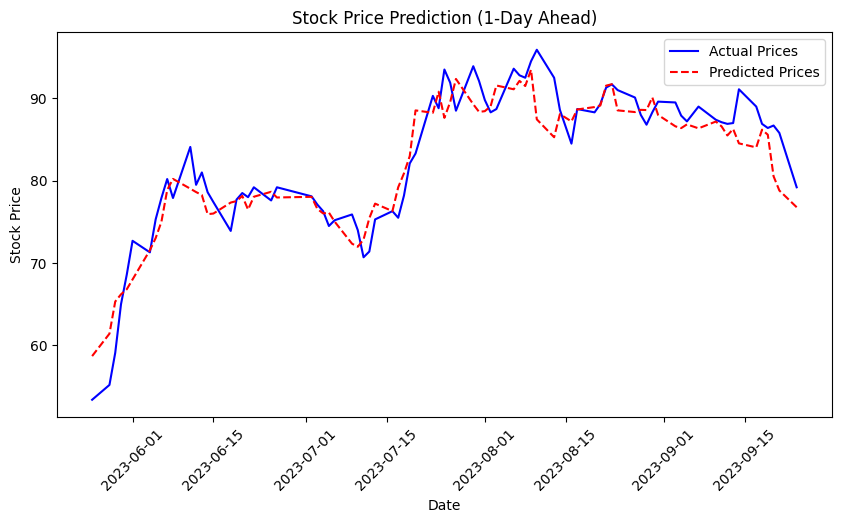


### Training for 3-day ahead prediction ###
Epoch 0, Loss: 0.044252
Epoch 10, Loss: 0.004475
Epoch 20, Loss: 0.003743
Epoch 30, Loss: 0.003612
Epoch 40, Loss: 0.003411
Epoch 50, Loss: 0.003020
Epoch 60, Loss: 0.003215
Epoch 70, Loss: 0.002305
Epoch 80, Loss: 0.002076
Epoch 90, Loss: 0.002376
[Timestamp('2023-09-21 00:00:00'), Timestamp('2023-09-20 00:00:00'), Timestamp('2023-09-19 00:00:00'), Timestamp('2023-09-18 00:00:00'), Timestamp('2023-09-17 00:00:00'), Timestamp('2023-09-14 00:00:00'), Timestamp('2023-09-13 00:00:00'), Timestamp('2023-09-12 00:00:00'), Timestamp('2023-09-11 00:00:00'), Timestamp('2023-09-10 00:00:00'), Timestamp('2023-09-07 00:00:00'), Timestamp('2023-09-05 00:00:00'), Timestamp('2023-09-04 00:00:00'), Timestamp('2023-09-03 00:00:00'), Timestamp('2023-08-31 00:00:00'), Timestamp('2023-08-30 00:00:00'), Timestamp('2023-08-29 00:00:00'), Timestamp('2023-08-28 00:00:00'), Timestamp('2023-08-27 00:00:00'), Timestamp('2023-08-24 00:00:00'), Timestamp('2023-08-23 00:

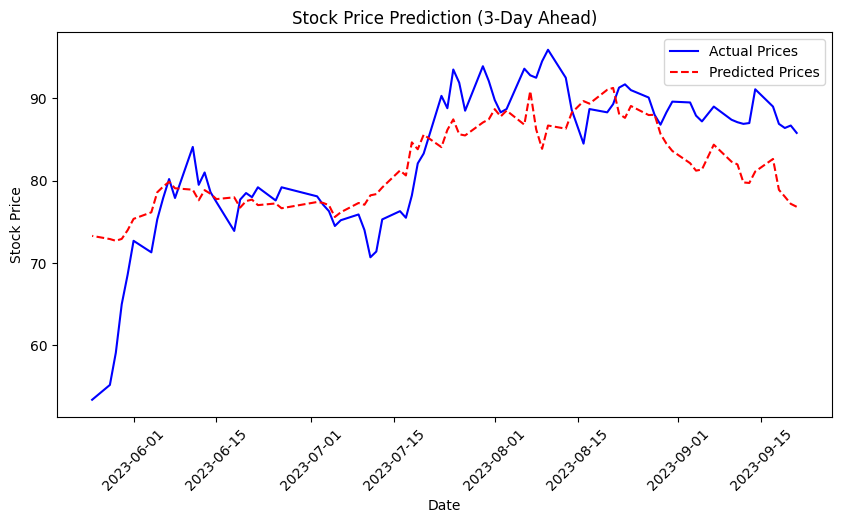


### Training for 5-day ahead prediction ###
Epoch 0, Loss: 0.040139
Epoch 10, Loss: 0.006281
Epoch 20, Loss: 0.005324
Epoch 30, Loss: 0.007096
Epoch 40, Loss: 0.004967
Epoch 50, Loss: 0.004686
Epoch 60, Loss: 0.004915
Epoch 70, Loss: 0.006142
Epoch 80, Loss: 0.004149
Epoch 90, Loss: 0.001986
[Timestamp('2023-09-21 00:00:00'), Timestamp('2023-09-20 00:00:00'), Timestamp('2023-09-19 00:00:00'), Timestamp('2023-09-18 00:00:00'), Timestamp('2023-09-17 00:00:00'), Timestamp('2023-09-14 00:00:00'), Timestamp('2023-09-13 00:00:00'), Timestamp('2023-09-12 00:00:00'), Timestamp('2023-09-11 00:00:00'), Timestamp('2023-09-10 00:00:00'), Timestamp('2023-09-07 00:00:00'), Timestamp('2023-09-05 00:00:00'), Timestamp('2023-09-04 00:00:00'), Timestamp('2023-09-03 00:00:00'), Timestamp('2023-08-31 00:00:00'), Timestamp('2023-08-30 00:00:00'), Timestamp('2023-08-29 00:00:00'), Timestamp('2023-08-28 00:00:00'), Timestamp('2023-08-27 00:00:00'), Timestamp('2023-08-24 00:00:00'), Timestamp('2023-08-23 00:

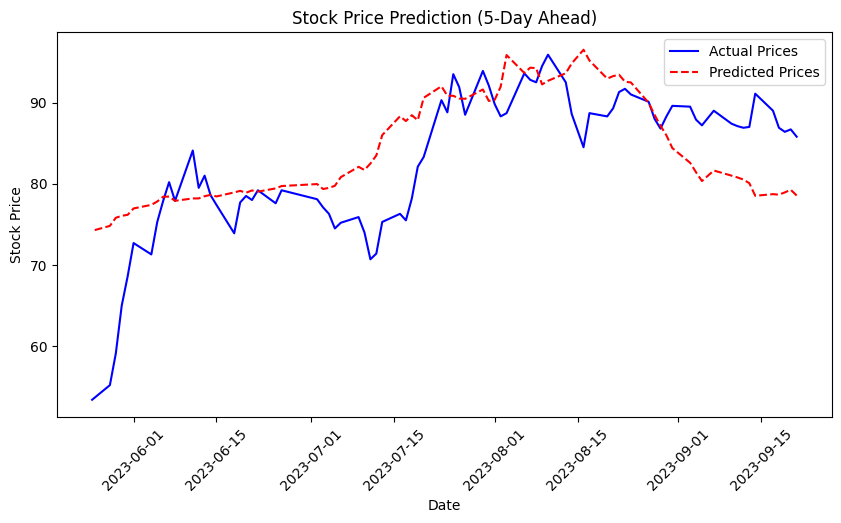


### Training for 10-day ahead prediction ###
Epoch 0, Loss: 0.043527
Epoch 10, Loss: 0.008280
Epoch 20, Loss: 0.006704
Epoch 30, Loss: 0.003219
Epoch 40, Loss: 0.002656
Epoch 50, Loss: 0.002529
Epoch 60, Loss: 0.001316
Epoch 70, Loss: 0.001479
Epoch 80, Loss: 0.001114
Epoch 90, Loss: 0.000882
[Timestamp('2023-09-20 00:00:00'), Timestamp('2023-09-19 00:00:00'), Timestamp('2023-09-18 00:00:00'), Timestamp('2023-09-17 00:00:00'), Timestamp('2023-09-14 00:00:00'), Timestamp('2023-09-13 00:00:00'), Timestamp('2023-09-12 00:00:00'), Timestamp('2023-09-11 00:00:00'), Timestamp('2023-09-10 00:00:00'), Timestamp('2023-09-07 00:00:00'), Timestamp('2023-09-05 00:00:00'), Timestamp('2023-09-04 00:00:00'), Timestamp('2023-09-03 00:00:00'), Timestamp('2023-08-31 00:00:00'), Timestamp('2023-08-30 00:00:00'), Timestamp('2023-08-29 00:00:00'), Timestamp('2023-08-28 00:00:00'), Timestamp('2023-08-27 00:00:00'), Timestamp('2023-08-24 00:00:00'), Timestamp('2023-08-23 00:00:00'), Timestamp('2023-08-22 00

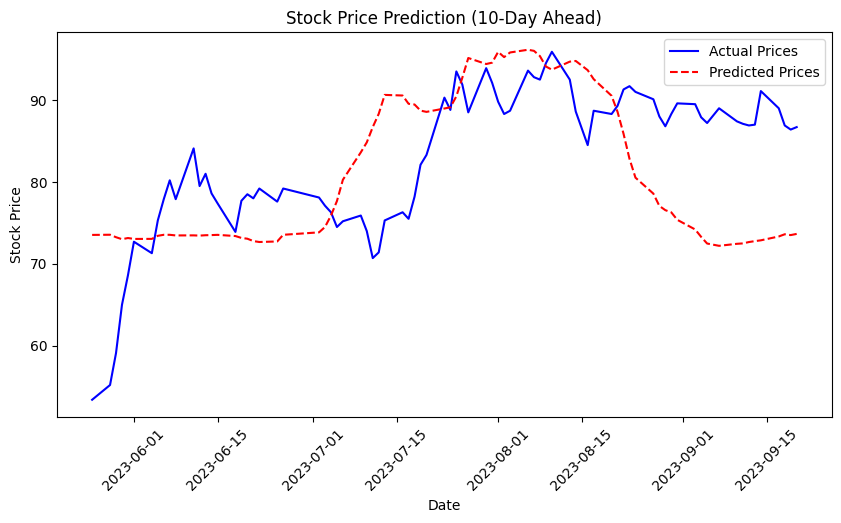


### Training for 15-day ahead prediction ###
Epoch 0, Loss: 0.041209
Epoch 10, Loss: 0.005555
Epoch 20, Loss: 0.003132
Epoch 30, Loss: 0.003145
Epoch 40, Loss: 0.002395
Epoch 50, Loss: 0.002157
Epoch 60, Loss: 0.001612
Epoch 70, Loss: 0.002367
Epoch 80, Loss: 0.001606
Epoch 90, Loss: 0.001323
[Timestamp('2023-09-19 00:00:00'), Timestamp('2023-09-18 00:00:00'), Timestamp('2023-09-17 00:00:00'), Timestamp('2023-09-14 00:00:00'), Timestamp('2023-09-13 00:00:00'), Timestamp('2023-09-12 00:00:00'), Timestamp('2023-09-11 00:00:00'), Timestamp('2023-09-10 00:00:00'), Timestamp('2023-09-07 00:00:00'), Timestamp('2023-09-05 00:00:00'), Timestamp('2023-09-04 00:00:00'), Timestamp('2023-09-03 00:00:00'), Timestamp('2023-08-31 00:00:00'), Timestamp('2023-08-30 00:00:00'), Timestamp('2023-08-29 00:00:00'), Timestamp('2023-08-28 00:00:00'), Timestamp('2023-08-27 00:00:00'), Timestamp('2023-08-24 00:00:00'), Timestamp('2023-08-23 00:00:00'), Timestamp('2023-08-22 00:00:00'), Timestamp('2023-08-21 00

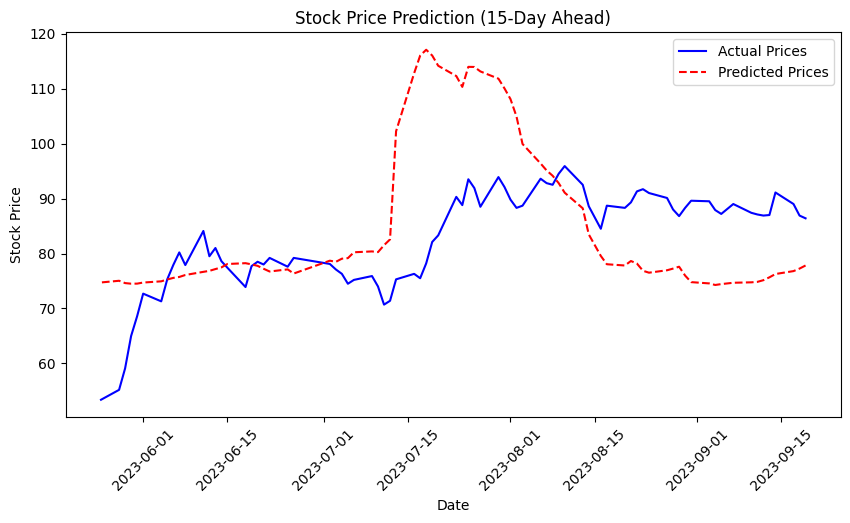

In [31]:
# Main Execution
if __name__ == "__main__":
    csv_file = "D:/Research/Top10BDStocksData/AIL2.csv"
    feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    target_column = 'Close'
    seq_length = 20
    forecast_horizons = [1, 3, 5, 10, 15]

    for horizon in forecast_horizons:
        print(f"\n### Training for {horizon}-day ahead prediction ###")
        X_train, y_train, X_test, y_test, scaler, target_scaler, dates = prepare_data(csv_file, feature_columns, target_column, seq_length, horizon)
        
        model = StockPredictor(input_size=len(feature_columns), hidden_size=64, num_layers=2, output_size=1)
        train_model(model, X_train, y_train, epochs=100, batch_size=32, lr=0.001)
        evaluate_model(model, X_test, y_test, scaler, target_scaler, dates, horizon)